# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [872]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

## Data Understanding (Gather and Assess)

in this section, we will read the data and assess it.

In [873]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### part 1: portfolio assessment

In [874]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [875]:
portfolio.shape

(10, 6)

In [876]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [877]:
# check the different offer types and how many we have in our data
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

### part 2: profile assessment

In [878]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [879]:
profile.shape

(17000, 5)

In [880]:
profile.describe(include = ['O'])
# we have  17000 unique profiles (id) and 3 gender types

,gender,id
count,14825,17000
unique,3,17000
top,M,534041374d564f06ad470c46a851464a
freq,8484,1


### part 3: transcript assessment

In [881]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [882]:
transcript.shape

(306534, 4)

In [883]:
# check the different events and how many time they appear in the dataset
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [884]:
# check if the number of customer matches the number of profiles
transcript.person.nunique()

17000

#### Examining missing values:
Here we tried to findout if there are any null values in the three dataframes. As we can see from the results:
 * both portfolio and transcript has no missing values
 * profile has missing values for gender and income colums in addition to the age which was incoded as 118

In [885]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [886]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [887]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

From the above observation, we want to check that if gender is null & income is null then te user age is missing. By running the line below, we got the same value which means each record that has one missing value in any of the 3 columns is missing a value in the other

In [888]:
profile[profile.gender.isnull() & profile.income.isnull() & profile.age.isin([118])]['age'].value_counts() 

118    2175
Name: age, dtype: int64

## Prepare and Clean Data

In this step, we will drop columns, rename columns, update some values and fill missing values

### Part 1: portfolio cleaning
we  need to:
* update the column name to merge later with other dataframes
* seperate values from channels column into different columns with 0/1 value

In [889]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

channels = set()
for i in portfolio.channels:
    channels.update(set(i))

for i in channels:
    portfolio[i] = portfolio.channels.apply(lambda x: 1 if i in x else 0)    

portfolio.drop(['channels'], axis=1, inplace=True)

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,mobile,email,web,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0


### Part 2: profile cleaning
 * we will replace age values with age groups for better analysis. 
 * replace became_member_on with membership year only and rename to year
 * fill null values
 * rename id to person to merge later with other dataframes


In [890]:
# update age
profile['age'] = pd.cut(profile.age, bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 117, 200], 
                               labels=['children', 'YA', '20s', '30s', '40s', '50s', '60s', '70s','80+','NA'])

# update year
profile["became_member_on"] = pd.to_datetime(profile.became_member_on, format = '%Y%m%d').apply(lambda x:x.year)

# fill null values
profile.gender.fillna('NA' , inplace=True)
profile.income.fillna(profile.income.mean() , inplace=True)

# rename columns
profile.rename(columns={'id': 'person'}, inplace=True)
profile.rename(columns={'became_member_on': 'year'}, inplace=True)

profile.head()

,gender,age,person,year,income
0,NA,NA,68be06ca386d4c31939f3a4f0e3dd783,2017,65404.991568
1,F,50s,0610b486422d4921ae7d2bf64640c50b,2017,112000.000000
2,NA,NA,38fe809add3b4fcf9315a9694bb96ff5,2018,65404.991568
3,F,70s,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.000000
4,NA,NA,a03223e636434f42ac4c3df47e8bac43,2017,65404.991568


### Part 3: transcript cleaning

 * for transcript, extract the value and create a new column for each value. 
 * merge two resulting columns
 * rename column for later merge with other datasets
 * fill null values

In [891]:
# extract information from the value field and create a new column for each type
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

# fix duplicated names of offer id and offer_id to have only one
transcript['temp'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])
transcript.drop(['value','offer id', 'offer_id'], axis=1, inplace=True)
transcript.rename(columns={'temp': 'offer_id'}, inplace=True)
transcript.rename(columns={'reward': 'gained_reward'}, inplace=True)

# fill null values
transcript.amount.fillna(0, inplace=True)
transcript.gained_reward.fillna(0, inplace=True)

transcript.head()

,person,event,time,amount,gained_reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [892]:
transcript.isnull().sum()

person                0
event                 0
time                  0
amount                0
gained_reward         0
offer_id         138953
dtype: int64

## Evaluate the Results ( Analyze and Visualize )

Here we cover three types of data evaluation: 
 1. General overview of Starbucks customers 
 2. Detailed analysis of Starbucks customer behavior in relation to different factors 
 3. Build a model to predict which users are more likely to view/complete offers

### Part 1: General overview of Starbucks customers

we see that males are almost half the customers, 36% are females while the remaining are either Ohter or they prefer not to say

<AxesSubplot:title={'center':'gender overview'}, ylabel='gender'>

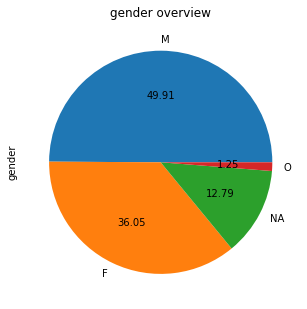

In [893]:
# Customer gender 
profile.gender.value_counts().plot(kind='pie', figsize=(5,10), autopct="%0.2f", title="gender overview")

As for the income information, we identified the average income for a Starbucks customer and looks at the income histogram to view income distribution which helps us gain a better idea of target group based on income

In [894]:
profile.income.mean()

65404.9915682968

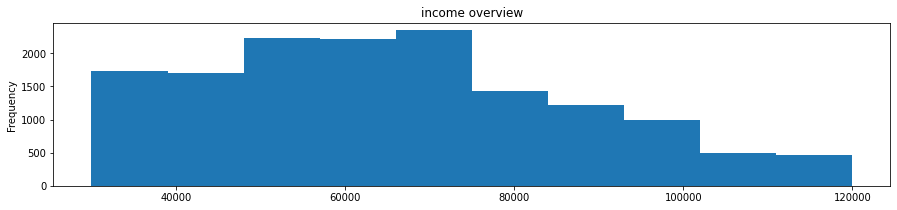

In [895]:
# here i excluded the profile with missing icomes and i did tht by excluding the age=NA since we know that
# a missing value in one column will be missing from the other
profile[profile.age != 'NA'].income.plot(kind='hist',title='income overview', figsize=(15,3));

Also age is a good indicator, here we viewed in general for Starbucks customer base, these are a number of customers in each age group.

<AxesSubplot:title={'center':'age groups overview'}>

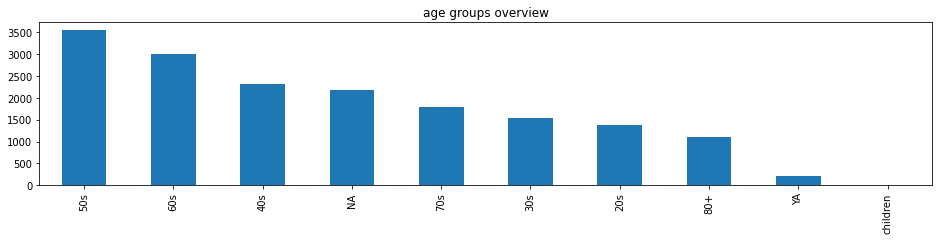

In [896]:
profile.age.value_counts().plot(kind='bar', figsize=(16,3), title='age groups overview')

We also checked which year, most users became member in. Seems 2017 had a good advertisement strategy

<AxesSubplot:title={'center':'membership year overview'}>

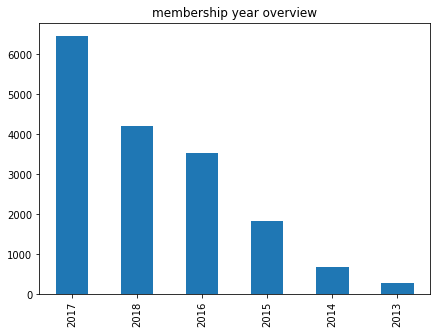

In [897]:
profile.year.value_counts().plot(kind='bar', title='membership year overview', figsize=(7,5))

Get more information on how gender, age and for income relate to the customers. For this, we will exclude null values as they won't add any benefit 

In [898]:
temp = profile[profile.age != 'NA']

<AxesSubplot:title={'center':'customer age by gender'}, xlabel='age'>

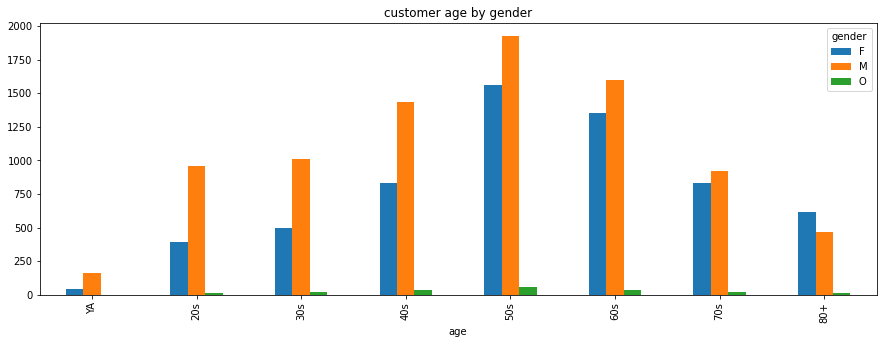

In [899]:
pd.crosstab(temp.age,temp.gender).plot(kind='bar',  figsize=(15,5), title='customer age by gender')

<AxesSubplot:title={'center':'customer age by gender'}, xlabel='age'>

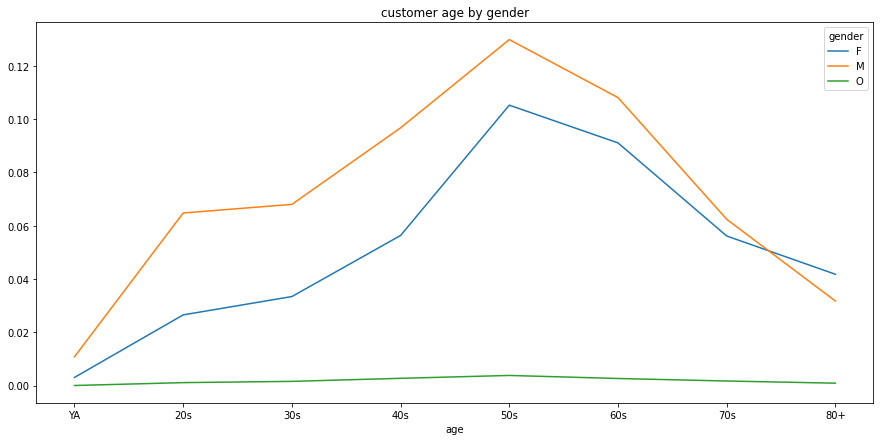

In [900]:
# a different view of the same data
pd.crosstab(temp.age,temp.gender, normalize="all").plot(kind="line",  figsize = (15,7), title='customer age by gender')

array([[<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>],
       [<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>],
       [<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>]], dtype=object)

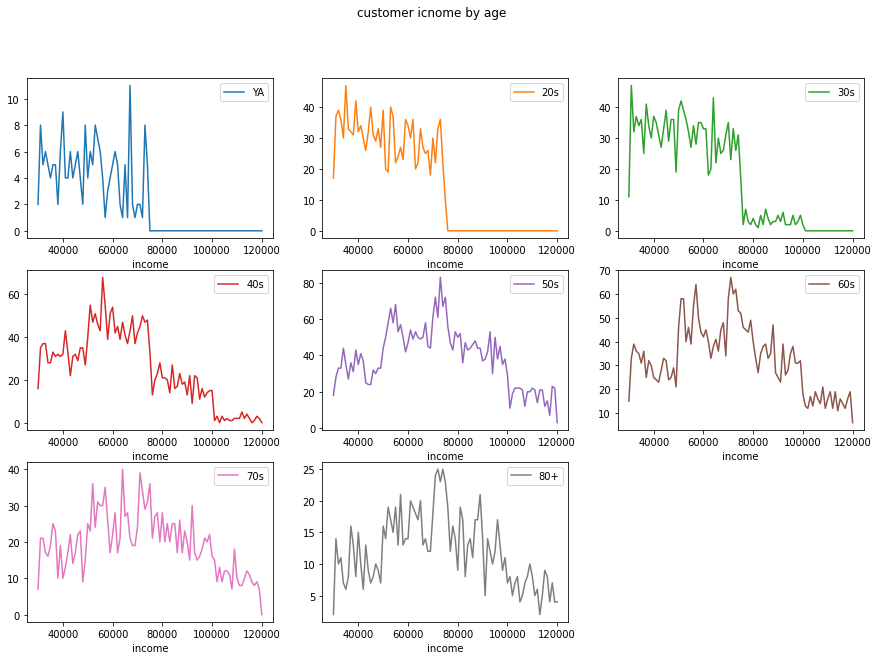

In [901]:
pd.crosstab(temp.income, temp.age).plot(subplots=True,  figsize = (15,10),layout=(3, 3), sharex=False, title='customer icnome by age')

<AxesSubplot:title={'center':'customer income by gender'}, xlabel='income'>

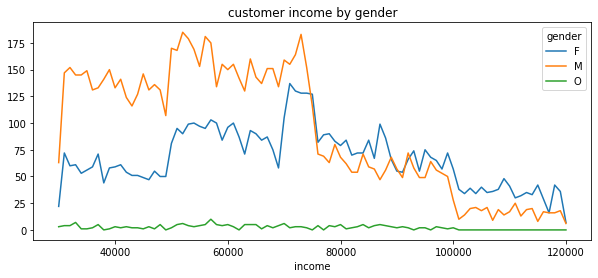

In [902]:
pd.crosstab(temp.income, temp.gender).plot( figsize = (10,4), title='customer income by gender')

### Part 2: Detailed analysis of setbacks customer behaviour in relation to different factors 

Here We will examine the data to see for a random set of 40 customers, the different events they were involved in during the experiment. This would provide some idea on how people behave for example: 
* some people never complete an offer even though they have transactions 
* in general, many customers who received offers viewed them. 
* people with more transactions are more likely to complete offers

<AxesSubplot:title={'center':'40 customer events overview'}, xlabel='person'>

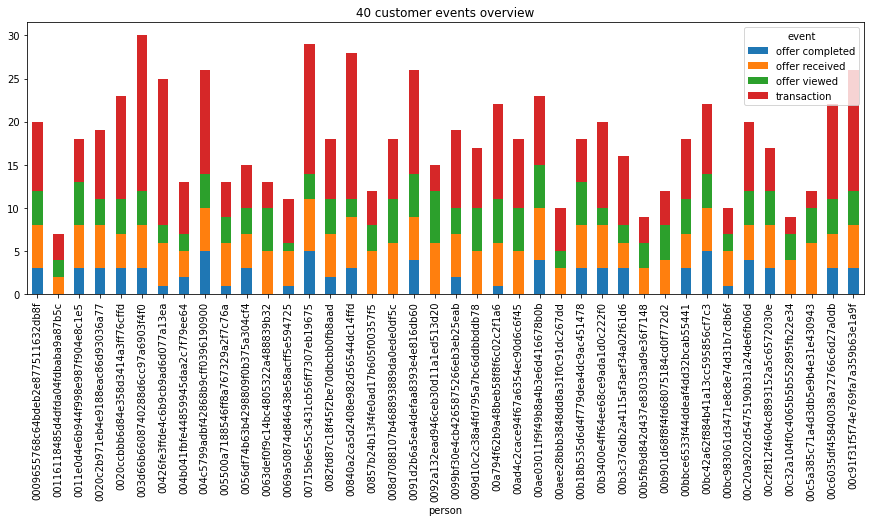

In [903]:
pd.crosstab(transcript.person,transcript.event).head(40).plot(kind='bar', stacked=True, figsize=(15,5), title='40 customer events overview')

Then we look at which offer types of offers have more views and completion. People are more likely to view BOGO offers. However, the discount offers has a slightly more complete event. However, this value is not very accurate because people might complete offers without seeing them.

We also notice that many customers who receive the informational offers would view them.

<AxesSubplot:title={'center':'offer events overview'}, xlabel='offer_type'>

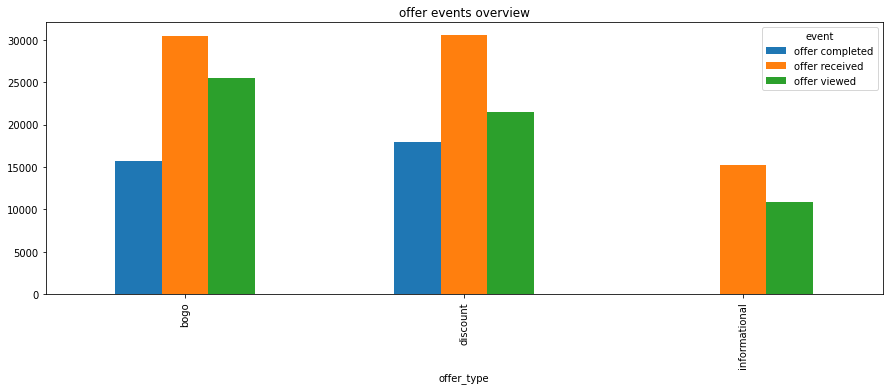

In [904]:
transcript_portfolio = pd.merge(transcript, portfolio, how='left', on='offer_id')
pd.crosstab(transcript_portfolio.offer_type,transcript_portfolio.event).plot(kind='bar', figsize=(15,5), title='offer events overview')

Now we see which 3 offers are more popular (have more completion events) and compare thier other attributes such as event type and channels

In [905]:
top_offers = transcript_portfolio[transcript_portfolio.event == 'offer completed'].offer_id.value_counts().head(3).reset_index()
top_offers.rename(columns={'index': 'offer_id', 'offer_id':'completed_count'}, inplace=True)
portfolio[portfolio['offer_id'].isin(top_offers.offer_id)]

,reward,difficulty,duration,offer_type,offer_id,mobile,email,web,social
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1


<AxesSubplot:title={'center':'top offer ids'}, ylabel='offer_id'>

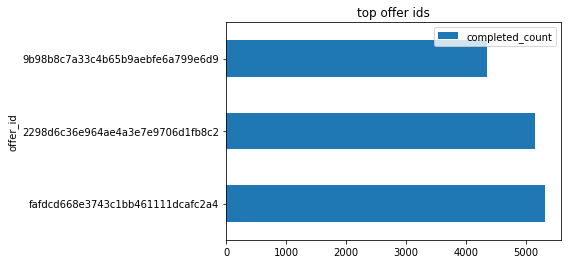

In [906]:
#plot top offers
top_offers.plot(y='completed_count', x='offer_id', kind='barh', title='top offer ids')

Checking which age group and which gender is more likely to spend more in starbucks.. we will limit our search to top 30 customers

<AxesSubplot:title={'center':'top 30 spenders age groups'}>

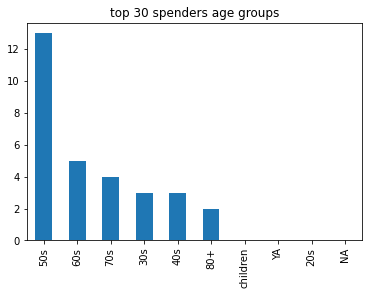

In [907]:
#customers who spent the most by age group
t = transcript[(transcript.amount != 0 )].groupby('person').amount.sum().reset_index().sort_values('amount', ascending=False)
top_paying_profiles = pd.merge(t,profile,how='left',on='person').head(30)
top_paying_profiles.age.value_counts().plot(kind='bar', title='top 30 spenders age groups')

<AxesSubplot:title={'center':'top 30 spenders gender'}, ylabel='gender'>

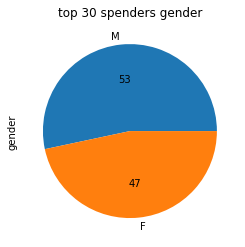

In [908]:
top_paying_profiles.gender.value_counts().plot(kind='pie', title='top 30 spenders gender', autopct="%0.0f")

Checking which age group and which gender is more likely to complete offers.. we will also limit our search to top 30 customers

<AxesSubplot:title={'center':'top 30 respondent customers age groups'}>

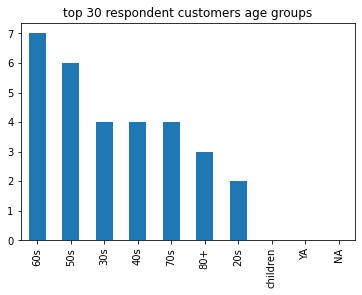

In [909]:
# most respondent customers
t = transcript[(transcript.event == 'offer completed')].groupby('person').event.count().reset_index().sort_values('event', ascending=False)
top_respondent_profiles = pd.merge(t,profile,how='left',on='person').head(30)
top_respondent_profiles.age.value_counts().plot(kind='bar', title='top 30 respondent customers age groups')

<AxesSubplot:title={'center':'top 30 respondent customers gender'}, ylabel='gender'>

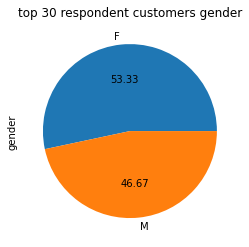

In [910]:
top_respondent_profiles.gender.value_counts().plot(kind='pie',autopct="%0.2f",  title='top 30 respondent customers gender')

Here will do a more detailed analysis covering:
1. which age group is more interested in what offer types covering all event types
2. which gender is more interested in what offer types covering all event types

In [911]:
transcript_profiles = pd.merge(transcript,profile,how='left',on='person')
all_merge = pd.merge(transcript_profiles,portfolio,on='offer_id')

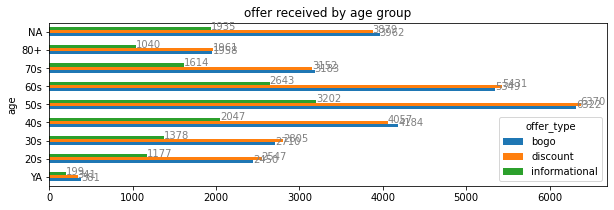

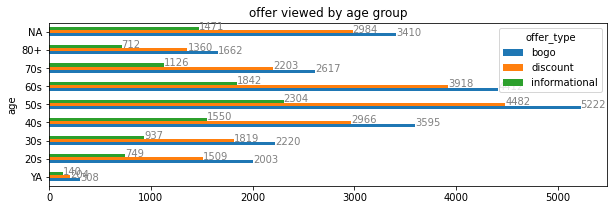

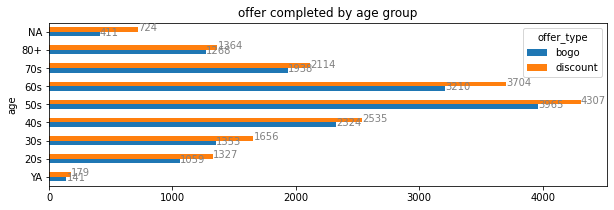

In [912]:
# age goups, offers and events
for i in transcript.event.unique():
    temp = all_merge[(all_merge.event == i )]
    t= pd.crosstab(temp["age"],temp["offer_type"])
    if t.shape[0] != 0:
        ax = t.plot(kind="barh",figsize=(10,3), title=i + ' by age group')
        for i in ax.patches:
            ax.text(i.get_width(), i.get_y()+.05, str(round((i.get_width()), 2)), color='grey')

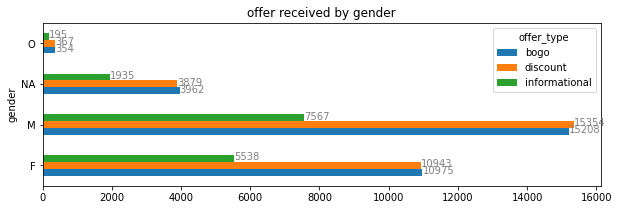

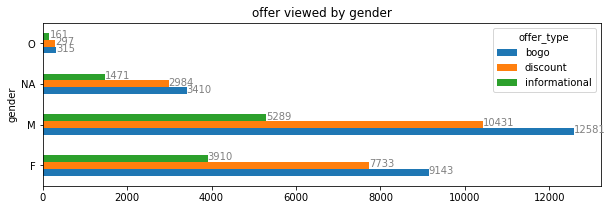

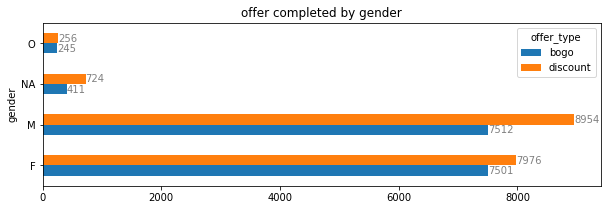

In [913]:
# gender, offers and events
for i in transcript.event.unique():
    temp = all_merge[(all_merge.event == i )]
    t= pd.crosstab(temp["gender"],temp["offer_type"])
    if t.shape[0] != 0:
        ax = t.plot(kind="barh",figsize=(10,3), title=i + ' by gender')
        
        for i in ax.patches:
            ax.text(i.get_width(), i.get_y()+.05, str(round((i.get_width()), 2)), color='grey')

### Part 3:  Build a model to predict which users are more likely to view then complete offers

Predict if a customer would view then complete an offer or now

#### Part 3.1: prepare the dataset
* seperate channels into columns and assign 0/1 values
* create new column for category columns with 0/1 values (offer types, gender, event, age)
* get only users who viewed offers then merge with users who completed offers
* drop unneeded columns
* fill nulls

In [914]:
df = all_merge.copy()

dummies = pd.get_dummies(df['offer_type'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['event'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['age'])
df = pd.concat([df, dummies], axis=1)

df.head()

,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2015,41000.0,...,0,0,0,0,0,1,0,0,0,0
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,40s,2016,33000.0,...,0,0,0,0,1,0,0,0,0,0
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,40s,2018,33000.0,...,0,0,0,0,1,0,0,0,0,0
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2017,80000.0,...,0,0,0,0,0,1,0,0,0,0


In [915]:
# get offer viewed rows 
df_view = df[df['offer viewed']==1]
df_view.drop(['offer completed'], axis = 1, inplace=True)

df_view.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
1245,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NA,NA,2015,65404.991568,...,0,0,0,0,0,0,0,0,0,1
1246,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2018,51000.000000,...,0,0,0,0,0,1,0,0,0,0
1247,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2018,72000.000000,...,0,0,0,0,0,1,0,0,0,0
1249,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,60s,2018,89000.000000,...,0,0,0,0,0,0,1,0,0,0
1250,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,60s,2018,66000.000000,...,0,0,0,0,0,0,1,0,0,0


In [916]:
df_complete = df[df['offer completed']==1][['offer_id','person', 'offer completed']]
df_complete.head()

,offer_id,person,offer completed
1248,9b98b8c7a33c4b65b9aebfe6a799e6d9,629fc02d56414d91bca360decdfa9288,1
1254,9b98b8c7a33c4b65b9aebfe6a799e6d9,b860d355ef6e4c66b5d5a837c56ef32d,1
1255,9b98b8c7a33c4b65b9aebfe6a799e6d9,99297ea01107436fa8c2e2bc86f55d89,1
1263,9b98b8c7a33c4b65b9aebfe6a799e6d9,16dc4306258b4fef90ffe99f53ed7952,1
1267,9b98b8c7a33c4b65b9aebfe6a799e6d9,0454292436bd4cee98e8ec873e30433e,1


In [917]:
final_df = df_view.merge(df_complete,right_on=['offer_id','person'],left_on=['offer_id','person'],how='left')

final_df.head()

,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NA,NA,2015,65404.991568,...,0,0,0,0,0,0,0,0,1,NaN
1,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2018,51000.000000,...,0,0,0,0,1,0,0,0,0,1.0
2,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2018,72000.000000,...,0,0,0,0,1,0,0,0,0,1.0
3,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,60s,2018,89000.000000,...,0,0,0,0,0,1,0,0,0,NaN
4,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,60s,2018,66000.000000,...,0,0,0,0,0,1,0,0,0,NaN


In [918]:
#drop un-needed columns
final_df.drop(['offer_type','gender','year','event','gained_reward','person','offer_id',
               'time','offer received', 'offer viewed','age'], axis = 1, inplace=True)

In [919]:
final_df.fillna(0, inplace=True)

In [920]:
final_df.head()

,amount,income,reward,difficulty,duration,mobile,email,web,social,bogo,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,0.0,65404.991568,5,5,7,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0.0
1,0.0,51000.000000,5,5,7,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1.0
2,0.0,72000.000000,5,5,7,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1.0
3,0.0,89000.000000,5,5,7,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0.0
4,0.0,66000.000000,5,5,7,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0.0


In [921]:
final_df.columns

Index(['amount', 'income', 'reward', 'difficulty', 'duration', 'mobile',
       'email', 'web', 'social', 'bogo', 'discount', 'informational', 'F', 'M',
       'NA', 'O', 'children', 'YA', '20s', '30s', '40s', '50s', '60s', '70s',
       '80+', 'NA', 'offer completed'],
      dtype='object')

#### Part 3.2: create the model (train, predict and score)

In [922]:
def create_model(classifer, df):    
    """
    a function that will create a model: train -> predict -> score -> print result
              
    args:
    classifer: object of classifer
    df: dataframe ready for training that must have "offer completed" column
    
    """
    
    print('Training with ' + str(classifer).removesuffix('()') + "...")
    
    features = df.drop(['offer completed'], axis = 1)
    target = df['offer completed']
    
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

    # fit classifier
    clf = classifer.fit(X_train, y_train)

    # predict on training and test data
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # accuracy on training and test data
    score_train = accuracy_score( y_train , predict_train )
    score_test = accuracy_score( y_test , predict_test )

    # display classifier clf_result dict 
    print('Training Accuracy:' , score_train)
    print('Testing Accuracy :', score_test)

In [923]:
create_model(AdaBoostClassifier(), final_df)
create_model(GaussianNB(), final_df)
create_model(DecisionTreeClassifier(), final_df)
create_model(RandomForestClassifier(), final_df)

Training with AdaBoostClassifier...
Training Accuracy: 0.8095842142353771
Testing Accuracy : 0.8079246194733027
Training with GaussianNB...
Training Accuracy: 0.775113258834189
Testing Accuracy : 0.7739188209712491
Training with DecisionTreeClassifier...
Training Accuracy: 0.8507198228128461
Testing Accuracy : 0.783522589997584
Training with RandomForestClassifier...
Training Accuracy: 0.8507198228128461
Testing Accuracy : 0.7933679632761537


## Deploy

a link to the report (article) of my analysis is available in the readme file. 